# Business Objective

The document classification solution should significantly reduce the manual human effort in the HRM,<br> it should achieve a higher level of accuracy and automation with minimal human intervention.


In [69]:
# removing warnings
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Importing libraries
import re
import os
import spacy
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
from time import time
# import tensorflow as tf
from sklearn.svm import SVC
from functools import reduce
# from keras.layers import Dense
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from xgboost import XGBClassifier
import plotly.graph_objects as go
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier
# from keras.models import Sequential
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from plotly.subplots import make_subplots
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV

# Data Gathering and Preprocessing

In [2]:
# Importing the dataframe which we have made from "Gathering data.ipynb" 
resumes_df=pd.read_csv('resumes_df.csv')
resumes_df.head()

,Texts,Category,Doc Type
0,ANIL KUMAR MADDUKURI \t\t\n\nSQL & MSBI Devel...,SQL Developer Lightning insight,docx
1,RAJU PAVANA KUMARI\n\n\n\n\t\n\n\tProfessional...,SQL Developer Lightning insight,docx
2,SQL AND MSBI DEVELOPER\n\nSQL AND MSBI DEVELOP...,SQL Developer Lightning insight,docx
3,\n\nCareer objective\n\n\nA rewarding opportun...,SQL Developer Lightning insight,doc
4,\n SQL S...,SQL Developer Lightning insight,doc


# EDA

In [3]:
# Total resumes we have
len(resumes_df)

77

In [4]:
def clean_it(txt):
    txt = txt.replace('\t',' ')
    txt = txt.replace('\n',' ')
    
    txt = re.sub(r'http\S+', '', (txt))                                                     # removing links
    txt = re.sub('[^a-z ]','', txt.lower())                                                 # only need alphabets also converting to lower case letters for convenience
    # txt = txt.split()                           
    txt = word_tokenize(txt)                                                                # tokenizing each words
    txt = [WordNetLemmatizer().lemmatize(x) for x in txt if x not in stopwords.words() ]    # removing stopwords and using lemmatization for root words
    txt = [x for x in txt if len(x.strip())>2]                                              # removing words containing less than 2 letters
    
    return " ".join(txt)

In [5]:
# Cleaning resumes
resumes_df['Cleaned_txt'] = resumes_df['Texts'].apply(clean_it)
resumes_df.head()

,Texts,Category,Doc Type,Cleaned_txt
0,ANIL KUMAR MADDUKURI \t\t\n\nSQL & MSBI Devel...,SQL Developer Lightning insight,docx,anil kumar maddukuri sql msbi developer summar...
1,RAJU PAVANA KUMARI\n\n\n\n\t\n\n\tProfessional...,SQL Developer Lightning insight,docx,raju pavana kumari professional summary year p...
2,SQL AND MSBI DEVELOPER\n\nSQL AND MSBI DEVELOP...,SQL Developer Lightning insight,docx,sql msbi developer sql msbi developer vinod ku...
3,\n\nCareer objective\n\n\nA rewarding opportun...,SQL Developer Lightning insight,doc,career objective rewarding opportunity growtho...
4,\n SQL S...,SQL Developer Lightning insight,doc,sql server developer priyanka professional sum...


In [6]:
# removing duplicates if any
print('We have',resumes_df.duplicated(subset='Cleaned_txt').sum(),"duplicate rows")

We have 2 duplicate rows


In [7]:
resumes_df.drop_duplicates(subset='Cleaned_txt',inplace=True)

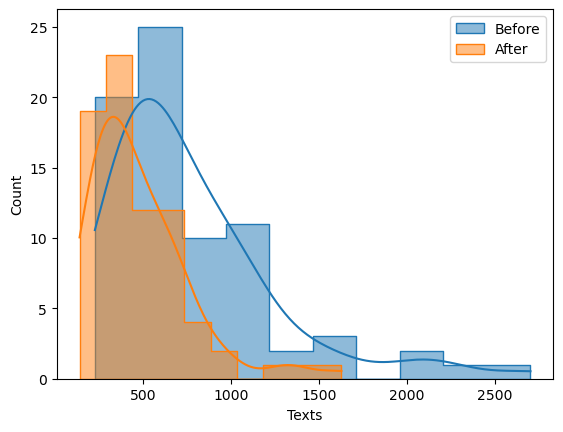

In [8]:
# How many words we have cleaned 

sn.histplot(resumes_df['Texts'].apply(lambda x:len(x.split())),label='Before',kde=True,element="step")
sn.histplot(resumes_df['Cleaned_txt'].apply(lambda x:len(x.split())),label='After',kde=True,element="step")
plt.legend()

In [9]:
# Checking unique categories
resumes_df['Category'].unique()

array(['SQL Developer Lightning insight', 'Peoplesoft resumes',
       'workday resumes', 'Reactjs'], dtype=object)

In [10]:
# Renaming them for our convenience
resumes_df['Category']=resumes_df['Category'].apply(lambda x: x.split()[0])     # only need the first word  

In [11]:
# rechecking 
resumes_df['Category'].unique()

array(['SQL', 'Peoplesoft', 'workday', 'Reactjs'], dtype=object)

* Checking how many resumes we have for each category

In [12]:
fig=go.Figure()

temp_df=resumes_df['Category'].value_counts()

fig.add_pie(labels=temp_df.index,
            values=temp_df.values,
            hoverinfo='skip',
            textinfo='label+value',
            textposition='outside')

colors = ['lightcyan','cyan','royalblue','darkblue']

fig.add_pie(labels=temp_df.index,
            values=temp_df.values,
            hoverinfo='skip',
            marker=dict(colors=colors,
                        line=dict(color='#090373',
                                  width=0.5)))


fig.update_layout(title='<b>Resume counts for each category</b>',
                  autosize=False,
                  template='plotly_dark',
                  showlegend=False)
fig.show()

We have imbalanced data.

* Document types

In [13]:
# Checking Different document types

fig=go.Figure()

temp_df=resumes_df['Doc Type'].value_counts()

colors = ['#1cfc03','#02a80d','#67f090','#3dfc76']

fig.add_pie(labels=temp_df.index,
            values=temp_df.values,
            textinfo='label+value',
            pull=[0.1,0.1,0.1],
            marker=dict(colors=colors,
                        line=dict(color='#03fccf',
                                  width=0.5)))


fig.update_layout(title='<b>Types of documents we have</b>',
                  template='plotly_dark',
                  autosize=False,
                  showlegend=False)
fig.show()

In [14]:
# Checking how many urls we have
resumes_df['links']=resumes_df['Texts'].apply(lambda x: len(re.findall('http',x)))

In [15]:
fig=go.Figure()

resume_contains_links=len(resumes_df[resumes_df['links']!=0])
fig.add_pie(labels=['Contain links','No Links Found'],
            values=[resume_contains_links,len(resumes_df)-resume_contains_links],
            hole=.5,
            pull=[0,0.1],
            marker=dict(colors=['#ff9500','#ffd000'][::-1],)
            )
fig.update_layout(autosize=False,
                  template='plotly_dark',
                  title='<br>How many resume have links in it<br>')

In [16]:
# What about each resume category [: Average links per category]
resumes_df[['links','Category']].groupby('Category').mean().style.background_gradient(cmap='Greens')

,links
Category,
Peoplesoft,0.150000
Reactjs,0.550000
SQL,0.071429
workday,0.000000


In [17]:
# defining a function to count words

def word_counter(series,top=20):
    
    words = []
    
    for string in series:
        words.extend(string.split())
            
    words,counts = np.unique(words,return_counts=True)
    
    if len(words) <= top:
        top = len(words)
    
    return sorted(zip(words,counts),
                  key=lambda x: x[1],
                  reverse=True)[:top]
        

* Most Frequent Words

In [18]:
temp_list = word_counter(resumes_df['Cleaned_txt'])[::-1]
x=[i[1] for i in temp_list]
fig = go.Figure()
fig.add_bar(y=[i[0] for i in temp_list],
            x=x,
            text=x,
            textposition='outside',
            orientation='h',
            hovertemplate="%{y}<br>%{x}<extra></extra>",
            marker=dict(color=x,
                        colorscale='blues'
                        ))
fig.update_layout(title='<b>Most frequent words</b>',
                  xaxis_title="Count",
                  template='simple_white',
                  height=600)

* Checking the same for each category 

In [19]:
cat_labels= resumes_df['Category'].unique()

fig=make_subplots(rows = 2, cols = 2,
                  subplot_titles = cat_labels,
                  horizontal_spacing=0.1,
                  vertical_spacing=0.1
                  )

row=1
col=1

for i in cat_labels:
    
    temp_list = word_counter(resumes_df[resumes_df['Category']==i]['Cleaned_txt'],15)[::-1]
    x=[i[1] for i in temp_list]
    
    fig.add_bar(y=[i[0] for i in temp_list],
            x=x,
            text=x,
            textposition='outside',
            orientation='h',
            hovertemplate="%{y}<br>%{x}<extra></extra>",
            marker=dict(color=x,
                        colorscale='Plotly3'
                        ),
            row=row,
            col=col)
    
    fig.update_layout(xaxis=dict(showline=False,))
    
    
    col+=1
    
    if col>2:
        col=1
        row+=1
    
fig.update_layout(title='<b>Frequent words for each class</b>',
                  showlegend=False,
                  template='simple_white',
                  height=700,)

for i in range(1,5):
    fig.update_layout(**{f'xaxis{i}':dict(showline=False,
                                          showticklabels=False,
                                          ticks=""
                                          )})
        
fig.show()

In different resumes same types of words are repeated.<br>
You must add your 'Experience' to your resume.

* Work cloud 

In [20]:
text=reduce(lambda x,y:x+' '+y, resumes_df['Cleaned_txt'])         # making all resumes to single text

(-0.5, 1399.5, 799.5, -0.5)

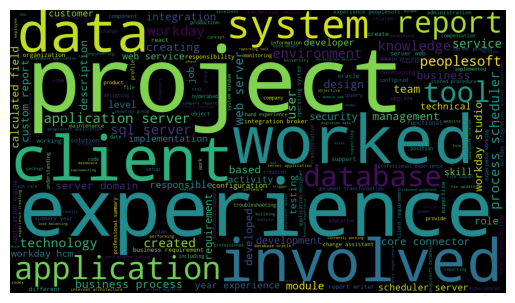

In [23]:
plt.imshow(WordCloud(width = 1400, 
                    height = 800,).generate(text))
plt.axis('off')

"Project" and "Experience" are the most in resume.<br>

* Checking for individual class

Text(0.5, 0.98, 'Word Cloud For Each Class')

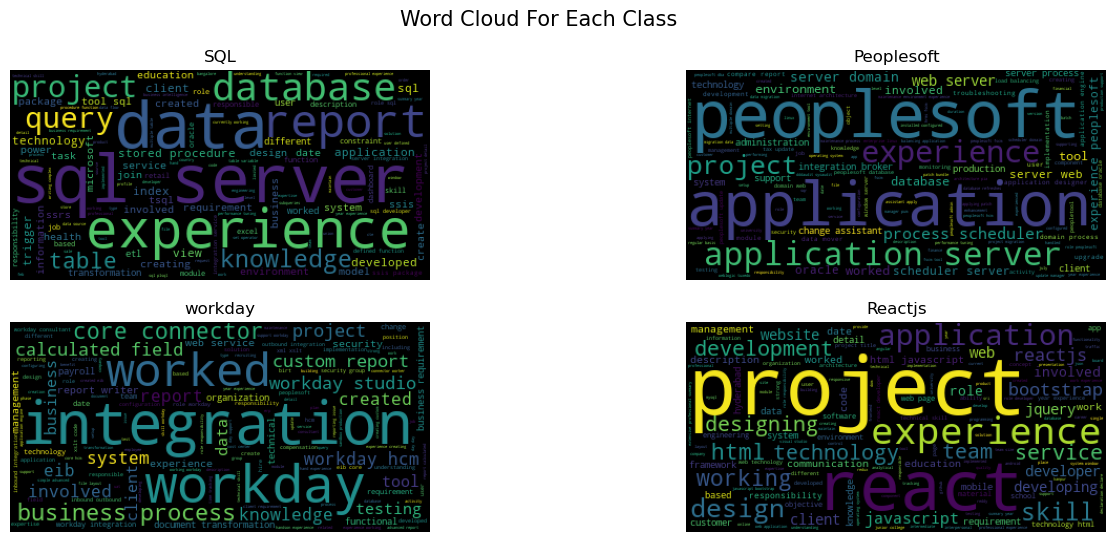

In [24]:
plt.figure(figsize=(16,6))

for n,i in enumerate(cat_labels):
    
    text=reduce(lambda x,y:x+' '+y, resumes_df[resumes_df['Category']==i]['Cleaned_txt'])
    
    plt.subplot(2,2,n+1)
    plt.imshow(WordCloud().generate(text))
    plt.axis('off')
    plt.title(i)

plt.suptitle('Word Cloud For Each Class',fontsize=15)

In [25]:
# Checking parts of speech
nlp=spacy.load('en_core_web_sm')

In [26]:
pos_df=pd.DataFrame(columns=cat_labels)

In [27]:
pos_df

,SQL,Peoplesoft,workday,Reactjs


In [28]:
for j in tqdm(cat_labels):
    
    text=reduce(lambda x,y:x+' '+y, resumes_df[resumes_df['Category']==j]['Texts'])
    for i in nlp(text):
        if i.pos_ in pos_df.index:
            if np.isnan(pos_df.loc[i.pos_,j]):
                pos_df.loc[i.pos_,j]=1
            else:
                pos_df.loc[i.pos_,j] += 1
        else:
            pos_df.loc[i.pos_,j] = 1

100%|██████████| 4/4 [00:21<00:00,  5.33s/it]


In [29]:
pos_df.head()

,SQL,Peoplesoft,workday,Reactjs
PROPN,2737,7144,5288,2798
SPACE,1351,5070,4608,2835
CCONJ,492,1185,1062,340
NUM,185,713,275,277
NOUN,2296,5187,5433,2908


<Axes: >

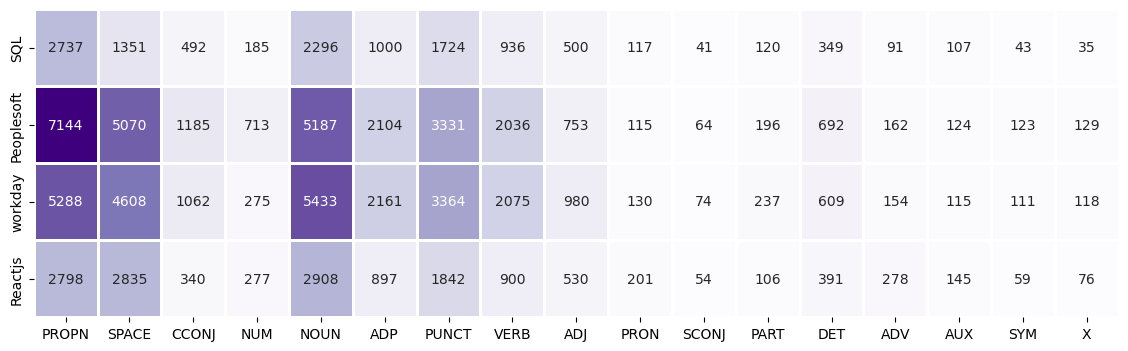

In [30]:
plt.figure(figsize=(14,4))
sn.heatmap(pos_df.dropna().astype('int').T,
           annot=True,
           fmt='.0f',
           cbar=False,
           linewidths=2,
           cmap='Purples'
           )

In [31]:
fig=go.Figure()
for i in pos_df.columns:
    fig.add_scatter(x=pos_df.index,
                    y=pos_df[i],
                    name=i)
fig.update_layout(template="plotly_dark",
                  hovermode='x unified',
                  title="Parts Of Speech count")
fig.show()

Noun, Pronoun and verbs are used More.

* Average Word Count

In [32]:
avg_word_count_df=resumes_df.iloc[:,[1,-2]].groupby('Category').agg(lambda x: len(x.sum().split())/len(x)).sort_values(by='Cleaned_txt',ascending=False)
avg_word_count_df

,Cleaned_txt
Category,
Peoplesoft,632.650000
workday,574.047619
SQL,404.500000
Reactjs,269.500000


In [33]:
fig = go.Figure(go.Funnel(x=avg_word_count_df.Cleaned_txt.astype('int'),
                          y=avg_word_count_df.index,
                          marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
                                    "line": {"width": [4, 2, 2, 3, 1],
                                             "color": ["wheat", "wheat", "blue", "wheat",]}},
                          connector = {"line": {"color": "royalblue",
                                                "dash": "dot",
                                                "width": 3}
                                       }))

fig.update_layout(autosize=False,
                  title="<b>Average word count in each resume type</b>",
                  template="plotly_dark")
fig.show()

Before model building we need to vactorize our text so as to feed algorithms.   

In [34]:
# Using tfidf vectorizer
tfidf= TfidfVectorizer()

In [35]:
# tfidf will return a sparse matrix so converting them to array
vectorized_x=tfidf.fit_transform(resumes_df['Cleaned_txt']).toarray()

In [36]:
vectorized_x[:5,:5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.02681418, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [37]:
# labels are in string data type
# encoding them

le = LabelEncoder()

In [38]:
# Applying on category column
target_y=le.fit_transform(resumes_df['Category'])

In [ ]:
# sn.heatmap(pd.DataFrame(vectorized_x).corr())

# Model Building

In [39]:
# Since our data is imbalance, we have to use stratified techniques
cv=RepeatedStratifiedKFold(n_repeats=3, random_state=1)

In [40]:
def train_test_accuracy(x,y,model,indicator=False):

    train_scores=[]                                                     # To store scores of each folds(subset of data)
    test_scores=[]  
    
    for train_idx, test_idx in tqdm(cv.split(x, y)):                          # cv.split will return index of folds
        
        x_tr, y_tr = x[train_idx], y[train_idx]                         # now storing values to a new train and test set
        x_te, y_te = x[test_idx], y[test_idx]
        
        model.fit(x_tr, y_tr)                                           # fitted training set
        
        train_scores.append(accuracy_score(y_tr,
                                            model.predict(x_tr)))
        test_scores.append(accuracy_score(y_te,
                                            model.predict(x_te)))

    avg_train_scores=np.mean(train_scores)                              # Storing average accuracy
    avg_test_scores=np.mean(test_scores)
    
    
    if indicator:
        
        fig = go.Figure()

        common_attributes=dict(
                                gauge={
                                    'axis': {'range': [None, 1]},
                                    'threshold': {'line': {'color': "red", 
                                                            'width': 4},
                                                    'thickness': 0.75,
                                                    'value': 1},
                                    'bgcolor': "white",
                                    'bar': {'color': "#0406b0"},
                                    'steps': [
                                                {'range': [0, 0.7], 'color': '#fc9e5b'},
                                                {'range': [0.7, 0.9], 'color': '#99fc5b'}]
                                            },
                                mode = "number+gauge+delta",
                                delta={'reference': 1},
                                )
        fig.add_indicator(
                        **common_attributes,
                        value = avg_train_scores,
                        title = {'text': "Train Accuuracy"},
                        domain = {'x': [0,0.5], 'y': [0, 1]}
                        )
        fig.add_indicator(**common_attributes,
                        value = avg_test_scores,
                        title = {'text': "Test Accuuracy"},
                        domain = {'x': [0.5,1], 'y': [0, 1]}
                        )

        fig.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

        return fig
    
    
    return avg_train_scores,avg_test_scores                                # mean of accuracies we got
 

In [41]:
# To vrify model breifly

def check_my_score(x,y,model):
    """Gives confussion_matrix and classification_report for training and testing set.

    Args:
        model : takes a defined model
    """
    x_train,x_test,y_train,y_test = train_test_split(x,y,
                                                     test_size= 0.2,
                                                     random_state=1,
                                                     stratify=y)
    train_cm=confusion_matrix(y_train,model.predict(x_train))
    test_cm=confusion_matrix(y_test,model.predict(x_test))

    # plotting confusion metrics
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1,title='Train set')
    sn.heatmap(train_cm,annot=True,fmt=".0f",cmap='cool',cbar=False,)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1,2,2,title='Test set')
    sn.heatmap(test_cm,annot=True,fmt=".0f",cmap='icefire',cbar=False)
    plt.show()

    # Classification reports
    print('-'*17+'\nOn training set :\n'+'-'*17,'\n',classification_report(y_train,model.predict(x_train)))
    print('-'*16+'\nOn testing set :\n'+'-'*16,'\n',classification_report(y_test,model.predict(x_test)))
    

In [42]:
# Finding best model
def find_best_algo(x, y,return_frame=False):
    
    # initiating a dictionary
    models = {}
    
    # Storing model_names and model
    models['Logistic Regression']=LogisticRegression()                      # Logistic Regression
    models['KNN']=KNeighborsClassifier()                                    # KNN Classifier
    models['SVC']=SVC()                                                     # Support Vector Classifier
    models['Naive Bayes']=MultinomialNB()                                   # Naive Bayes Classifier
    models['Decision Tree']=DecisionTreeClassifier()                        # Decision Tree Classifier
    models['RandomForest']=RandomForestClassifier()                         # Random Forest Classifier
    models['Gradient Boosting']=GradientBoostingClassifier()                # Gradient Boosting Classifier
    models['AdaBoost']=AdaBoostClassifier()                                 # AdaBoost Classifier
    models['LightGBM']=LGBMClassifier()                                     # LightGBM Classifier
    models['XGBoost']=XGBClassifier()                                       # XGBoost Classifier
    models['Catboost']=CatBoostClassifier(verbose=0,                        # Catboost Classifier
                                          allow_writing_files=False)
    
    
    # DataFrane to store model results
    model_scores_df= pd.DataFrame(columns=['accuracy_train','accuracy_test'] )
    
    # Now iterating over each model
    for model_name, model in models.items():
        
        try:
            model.set_params(random_state=1)                                # Blocking randomness
        except:                                                             # Some of them are not supported
            pass
        
        # storing scores
        model_scores_df.loc[model_name]=train_test_accuracy(x,y,model,indicator=False)                                         
       
    
    
    if return_frame:
        return model_scores_df
    
    
    # The plot
    fig=go.Figure()
    x=model_scores_df.index
    
    colors=['#03d1ff','#00fc08']
    
    for i in range(2):
        
        fig.add_scatter(x=x,
                        y=model_scores_df.iloc[:,i],
                        marker=dict(color=colors[i]),
                        name=model_scores_df.columns[i])
        
    fig.update_layout(hovermode='x unified',
                    template='plotly_dark',
                    title='Comapring models')
    return fig
    


In [43]:
# finding which algorithm is the best
find_best_algo(vectorized_x, target_y)

15it [00:01, 12.47it/s]
15it [00:00, 31.89it/s]
15it [00:00, 20.48it/s]
15it [00:00, 208.46it/s]
15it [00:00, 102.81it/s]
15it [00:01,  8.87it/s]
15it [00:20,  1.37s/it]
15it [00:03,  4.77it/s]
15it [00:00, 17.90it/s]
15it [00:06,  2.44it/s]
15it [07:18, 29.26s/it]


Except 'CatBoostClassifier', none of them performed well.<br>
It that because of our data is imbalanced.<br>
Lets find out


In [44]:
# Using SMOTE to oversample our data

smote=SMOTE(random_state=1)

resampled_x,resampled_y=smote.fit_resample(vectorized_x, target_y)

In [45]:
# Checking distribution before and after over_sampling

before_sample=np.unique(target_y,return_counts=True)
after_sample=np.unique(resampled_y,return_counts=True)

pull=[0.01 for i in range(4)]
x=le.inverse_transform(before_sample[0])
fig=go.Figure()
fig.add_pie(labels=x,
            values=before_sample[1],
            name='Before',
            hole=0.3,
            sort=False,
            pull=pull,
            showlegend=False,
            marker=dict(colors=['#b1e84a','#8ffa48','#63f205','#4bb804']),
            )
fig.add_pie(labels=x,
            values=after_sample[1],
            name='After',
            hole=0.6,
            pull=pull,
            showlegend=False,
            marker=dict(colors=['#ffff03','#ffb200','#ff7b00','#cc543b']),
            )
fig.update_layout(autosize=False,
                  title='Distribution of target variable before and after sampling',
                  template='plotly_dark',
                  showlegend=False,)

fig.data[0].domain = {'x': [0,1], 'y': [0.25,0.75] }
fig.show()

In [46]:
# Again checking our Algos score
find_best_algo(resampled_x,resampled_y)

15it [00:00, 16.53it/s]
15it [00:00, 80.31it/s]
15it [00:00, 23.57it/s]
15it [00:00, 291.49it/s]
15it [00:00, 145.34it/s]
15it [00:01,  8.76it/s]
15it [00:21,  1.43s/it]
15it [00:03,  4.85it/s]
15it [00:00, 17.54it/s]
15it [00:04,  3.25it/s]
15it [06:52, 27.48s/it]


After over sampling, model's performance increased significantly.<br>
Naive Bayes is performing so well.

### 1. Naive Bayes

In [47]:
mnb=MultinomialNB()

In [48]:
# Showing accuracies before sampling
train_test_accuracy(vectorized_x, target_y,mnb,indicator=True)

15it [00:00, 274.01it/s]


In [49]:
# Showing accuracies After sampling
train_test_accuracy(resampled_x,resampled_y,mnb,indicator=True)

15it [00:00, 184.70it/s]


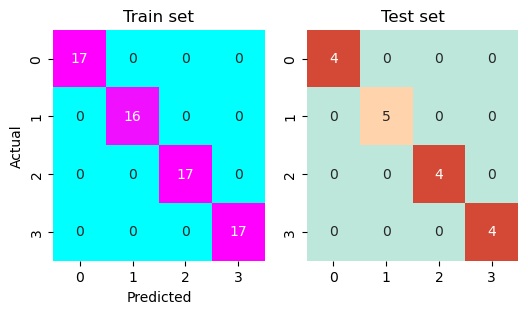

-----------------
On training set :
----------------- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        17

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

----------------
On testing set :
---------------- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [50]:
# Checking precision and recall
check_my_score(resampled_x,resampled_y,mnb)

### 2. Logistic Regression

In [51]:
lr=LogisticRegression(n_jobs=-1,
                      multi_class='multinomial',
                      random_state=1,
                      solver='saga',
                      max_iter=100000)

In [52]:
search_params={'C':(1e-6, 100.0, 'log-uniform'),
               'penalty':['elasticnet'],
               'l1_ratio':np.linspace(0,1,10)}

In [53]:
search = BayesSearchCV(estimator=lr,
                       search_spaces=search_params,
                       n_jobs=-1,
                       cv=cv,
                       random_state=1)

In [54]:
search.fit(vectorized_x,target_y)

/home/k/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
              estimator=LogisticRegression(max_iter=100000,
                                           multi_class='multinomial', n_jobs=-1,
                                           random_state=1, solver='saga'),
              n_jobs=-1, random_state=1,
              search_spaces={'C': (1e-06, 100.0, 'log-uniform'),
                             'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                             'penalty': ['elasticnet']})

In [55]:
search.best_params_

OrderedDict([('C', 10.507056203697442),
             ('l1_ratio', 0.3333333333333333),
             ('penalty', 'elasticnet')])

In [56]:
search.best_score_

1.0

In [57]:
lr.set_params(**search.best_params_)

LogisticRegression(C=10.507056203697442, l1_ratio=0.3333333333333333,
                   max_iter=100000, multi_class='multinomial', n_jobs=-1,
                   penalty='elasticnet', random_state=1, solver='saga')

In [58]:
train_test_accuracy(vectorized_x,target_y,lr,indicator=True)

15it [00:10,  1.49it/s]


Without oversampling, 100% accuracy can be achievable.

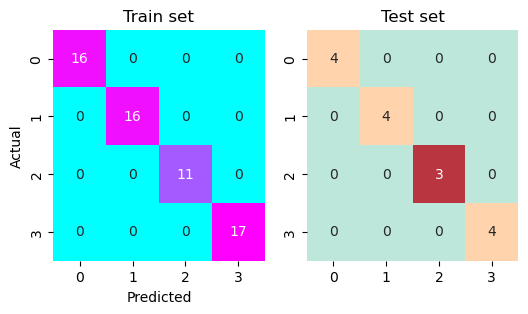

-----------------
On training set :
----------------- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        17

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

----------------
On testing set :
---------------- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [59]:
check_my_score(vectorized_x,target_y,lr)

3. KNN

In [70]:
knn=KNeighborsClassifier(n_jobs=-1)

In [71]:
param_grid={'p':[1,2],
            'n_neighbors':range(2,10),
            'weights':['uniform', 'distance'],
            'algorithm':['ball_tree', 'kd_tree', 'brute',None]}

In [72]:
gscv_knn = GridSearchCV(knn,
                        cv=cv,
                        n_jobs=-1,
                        param_grid=param_grid,
                        scoring='accuracy',
                        return_train_score=True)

In [73]:
gscv_knn.fit(vectorized_x,target_y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute', None],
                         'n_neighbors': range(2, 10), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [74]:
gscv_knn.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}

In [75]:
gscv_knn.best_score_

1.0

In [76]:
knn.set_params(**gscv_knn.best_params_)

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2)

In [77]:
train_test_accuracy(vectorized_x,target_y,knn,indicator=True)

15it [00:00, 41.10it/s]


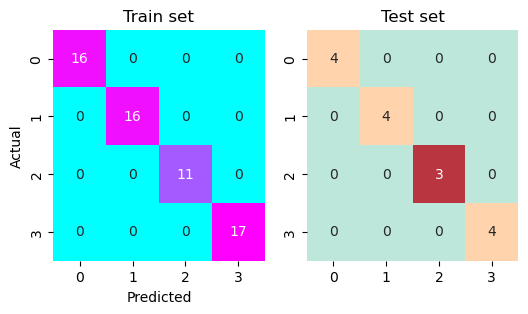

-----------------
On training set :
----------------- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        17

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

----------------
On testing set :
---------------- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [78]:
check_my_score(vectorized_x,target_y,knn)

### Validating our model

In [79]:
validation_df=pd.read_csv("validation_df.csv",)

In [80]:
# encoding our categories  
validation_y=le.transform(validation_df.Category)

In [81]:
validation_df['Cleaned Text']=validation_df.Texts.apply(clean_it)

In [82]:
validation_x=tfidf.transform(validation_df['Cleaned Text']).toarray()

In [83]:
# We will store all models prediction
model_preds={}

In [84]:
model_preds['Actual']=validation_y

model_preds['Naive Bayes']=mnb.predict(validation_x)
model_preds['Logistic Regression']=lr.predict(validation_x)
model_preds['K-Nearest Neighbour']=knn.predict(validation_x)

In [85]:
pd.DataFrame(model_preds).style.background_gradient(cmap='Set2',subset=['Actual']).background_gradient(cmap='Pastel2',subset=['Naive Bayes','Logistic Regression','K-Nearest Neighbour'])

,Actual,Naive Bayes,Logistic Regression,K-Nearest Neighbour
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,2,2,2,2
4,2,2,2,2
5,2,2,2,2


All of these algorithms are predicted correctly.<br> But which one to choose?

In [86]:
# Choosing a model which take less time to predict

time_takes = []

for i in [mnb,lr,knn]:
    
    temp_time_store=0
    
    for _ in range(3):
        start = time()
        i.predict(np.vstack((vectorized_x,validation_x)))
        temp_time_store+= time()-start
        
    time_takes.append(temp_time_store/3)


In [87]:
time_takes

[0.0017963250478108723, 0.0009993712107340496, 0.025060415267944336]

In [88]:
fig=go.Figure()

fig.add_bar(x=['Naive Bayes','Logistic Regression','K-Nearest Neighbour'],
            y=time_takes,
            marker=dict(color=time_takes,
                        colorscale='rainbow'),
            text=np.round(time_takes,4),
            hovertemplate='%{x}<br>%{y}<extra></extra>',
            textposition='outside',
            width=0.2
            )

fig.update_layout(title='Time Taken by Algorithm',
                  xaxis_title='Algorithm',
                  yaxis_title='Time Taken (s)',
                  template='plotly_dark',
                  autosize=False)

Lower is the better, hence 'Logistic Regression' is the choice.<br>
But for deployment purposes we will use the 'Naive Bayes'

#### Peparation for Deployment

making a pipeline

In [89]:
# Create a custom transformer class that wraps your function
class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func=clean_it):
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.func)

In [90]:
pipeline = Pipeline([
    ('my_transformer', MyTransformer()),
    ('vectorize',TfidfVectorizer()),
    ('model',KNeighborsClassifier(algorithm='ball_tree',
                                  n_jobs=-1, 
                                  n_neighbors=2))
])

In [91]:
pipeline.fit(resumes_df['Texts'],resumes_df['Category'])

Pipeline(steps=[('my_transformer', MyTransformer()),
                ('vectorize', TfidfVectorizer()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1,
                                      n_neighbors=2))])

In [92]:
pipeline.predict(validation_df['Texts'])

array(['Reactjs', 'Reactjs', 'Reactjs', 'SQL', 'SQL', 'SQL'], dtype=object)

In [93]:
validation_df

,Texts,Category,Cleaned Text
0,Jake Wilson\n\n(555) 555-5555 | jake@email.com...,Reactjs,jake wilson jakeemailcom denver linkedincomjak...
1,"FIRST LAST\nBay Area, California • +1-234-456-...",Reactjs,bay area california professionalemailresumewor...
2,First Last\nReact Front End Developer\nAugusta...,Reactjs,react front developer augusta professionalemai...
3,"First Last\nSQL Server Developer\nBay Area, Ca...",SQL,sql server developer bay area california profe...
4,"First Last\nJunior SQL Developer\nBurlington, ...",SQL,junior sql developer burlington vermont profes...
5,"FIRST LAST\nBay Area, California • +1-234-456-...",SQL,bay area california professionalemailresumewor...


In [94]:
# making a pickle file
pickle.dump(pipeline,open('pipeline.pkl','wb'))